<a href="https://colab.research.google.com/github/petitbato/Advanced_AI_Lab/blob/main/biases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disparate Impact Remover

This notebook demonstrates the ability of the Disparate Impact Remover algorithm, it's largely inspired by the example of  [the official AIF360 repository](https://github.com/Trusted-AI/AIF360/blob/main/examples/demo_disparate_impact_remover.ipynb). The Disparate Impact Remover is a pre-processing bias mitigation technique. Its goal is to reduce bias in the input data before training the model by editing the feature values so that they are less correlated with protected attributes, while still preserving as much of the data's utility as possible.
How it works:


1.       Identify protected attribute(s): E.g., gender, race.

2.   Adjust non-protected features: It transforms the feature values so that their distributions become more similar across different groups (e.g., men vs. women), reducing the ability of the model to learn group-specific patterns.

3.       Balance trade-off: There's a tunable parameter (often called repair_level) that determines how much to modify the features: 0.0 means no change (original data) and 1.0 means full repair (maximum fairness but potential loss of accuracy), values in between offer a trade-off.


**Disparate Impact (DI)** is a metric used to assess fairness in machine learning models and decision-making processes. It measures the ratio of the favorable outcome rate for the unprivileged group to the favorable outcome rate for the privileged group.

Mathematically:

$$ DI = \frac{Pr(favorableOutcome | unprivilegedGroup)}{Pr(favorableOutcome | privilegedGroup)} $$

## Import et installation


In [7]:
!pip install aif360
!pip install BlackBoxAuditing

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from matplotlib import pyplot as plt

import sys
sys.path.append("../")
import warnings

import numpy as np
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC as SVM
from sklearn.preprocessing import MinMaxScaler

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric


In [8]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data -O /usr/local/lib/python3.11/dist-packages/aif360/data/raw/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test -O /usr/local/lib/python3.11/dist-packages/aif360/data/raw/adult/adult.test
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names -O /usr/local/lib/python3.11/dist-packages/aif360/data/raw/adult/adult.names


--2025-05-14 09:54:24--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/usr/local/lib/python3.11/dist-packages/aif360/data/raw/adult/adult.data’

/usr/local/lib/pyth     [  <=>               ]   3.79M  9.37MB/s    in 0.4s    

2025-05-14 09:54:25 (9.37 MB/s) - ‘/usr/local/lib/python3.11/dist-packages/aif360/data/raw/adult/adult.data’ saved [3974305]

--2025-05-14 09:54:25--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/usr/local/lib/python3.11/dist-packages/

## Support functions

In [9]:
import seaborn as sns # Import seaborn for KDE plotting

def plot_histo(feature,level, data, data_repd, protected_attribute='sex', privileged_value='Male'):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Increased figure width
    # Original data (all)
    axes[0].set_title(f'{feature} original')

    # Repaired data (all)
    axes[1].set_title(f'{feature} repaired with repair level {level}')

    # Filter data for privileged and unprivileged groups based on the protected attribute
    privileged_group_indices = data.features[:, data.feature_names.index(protected_attribute)] == 1  # Assuming 1 represents privileged group
    unprivileged_group_indices = data.features[:, data.feature_names.index(protected_attribute)] == 0  # Assuming 0 represents unprivileged group

    # Plot KDEs for privileged and unprivileged groups on both subplots
    sns.kdeplot(data.features[privileged_group_indices, data.feature_names.index(feature)], ax=axes[0], label=privileged_value)
    sns.kdeplot(data.features[unprivileged_group_indices, data.feature_names.index(feature)], ax=axes[0], label=f'Not {privileged_value}')

    sns.kdeplot(data_repd.features[privileged_group_indices, data_repd.feature_names.index(feature)], ax=axes[1], label=privileged_value)
    sns.kdeplot(data_repd.features[unprivileged_group_indices, data_repd.feature_names.index(feature)], ax=axes[1], label=f'Not {privileged_value}')

    # Add legends to both subplots
    axes[0].legend()
    axes[1].legend()

    plt.show()

## Disparate Impact remover

In [10]:
# Define the protected attribute
protected = 'sex'  # The protected attribute is 'sex', indicating gender in this case

# Load the Adult Dataset with specified settings
ad = AdultDataset(
    protected_attribute_names=[protected],  # Specify 'sex' as the protected attribute
    privileged_classes=[['Male']],  # Define 'Male' as the privileged class for the protected attribute
    categorical_features=[],  # No categorical features are used in this analysis
    features_to_keep=['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']  # Select specific features for analysis
)

# Initialize a MinMaxScaler for feature scaling
scaler = MinMaxScaler(copy=False)  # Create a scaler object to scale features to a specific range

# Split the dataset into training and testing sets
test, train = ad.split([10000])  # Split the dataset, allocating 10000 samples for testing

# Scale the features in both training and testing sets
train.features = scaler.fit_transform(train.features)  # Fit the scaler on training data and transform it
test.features = scaler.fit_transform(test.features)  # Transform the testing data using the fitted scaler

# Get the index of the protected attribute in the feature names
index = train.feature_names.index(protected)  # Find the index of the protected attribute ('sex') in the feature names list




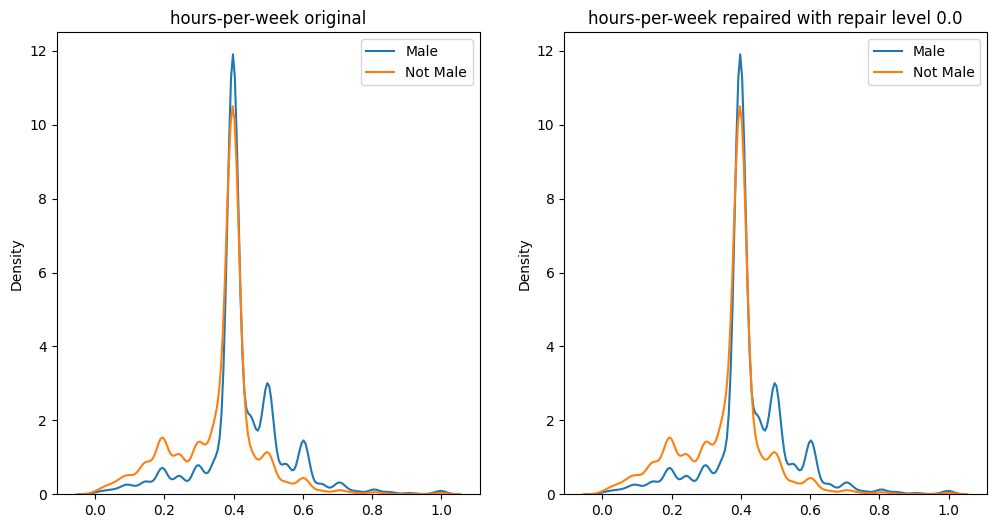

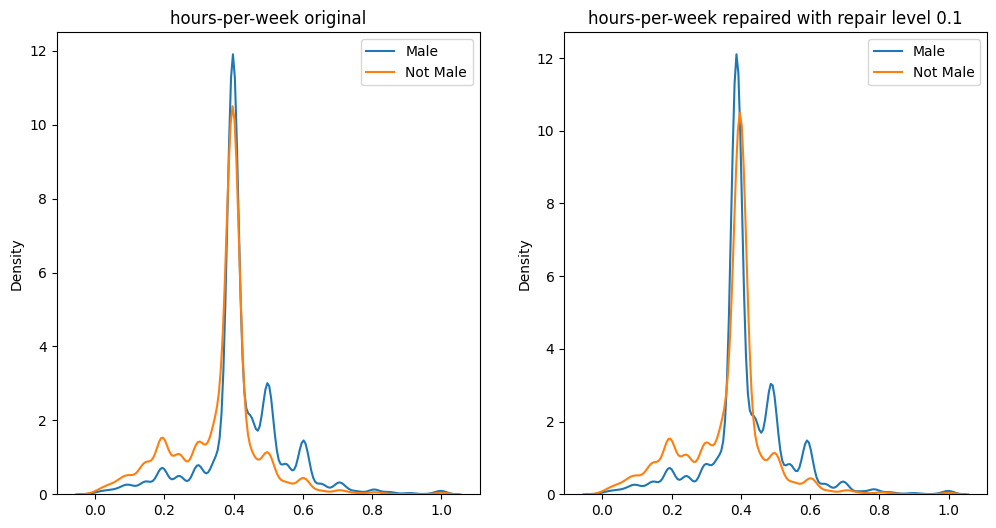

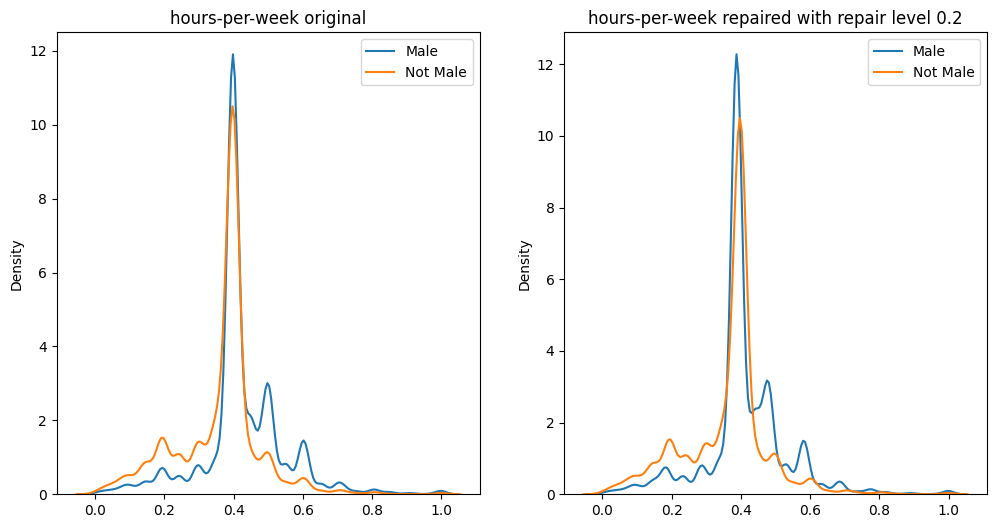

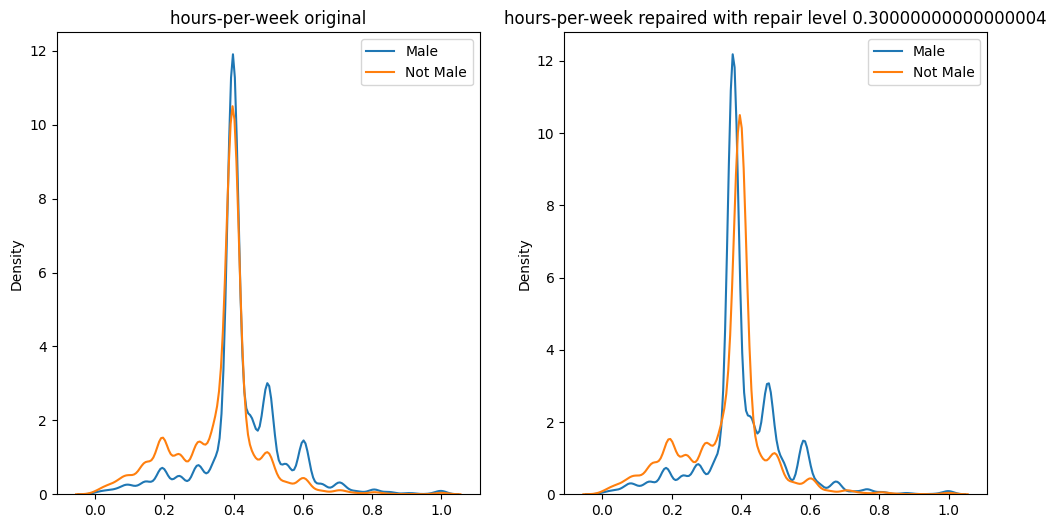

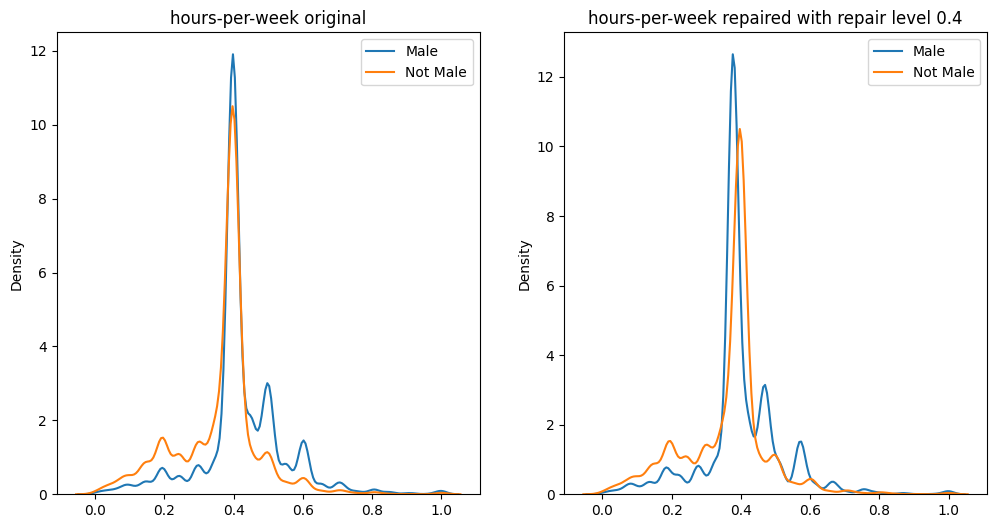

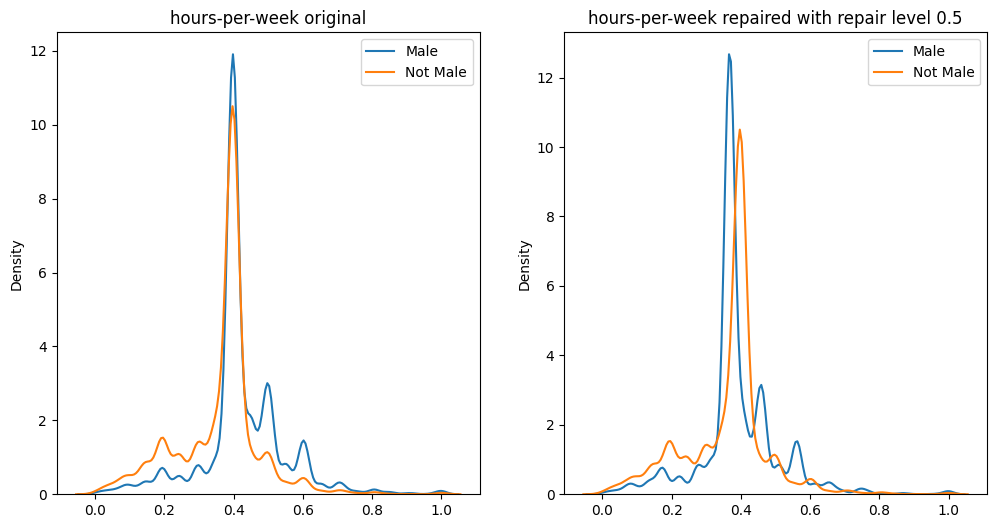

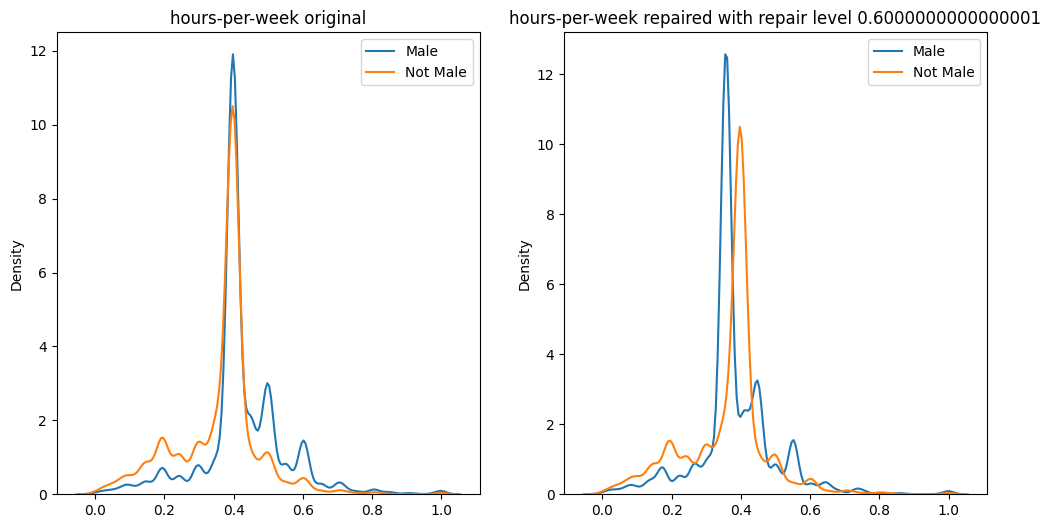

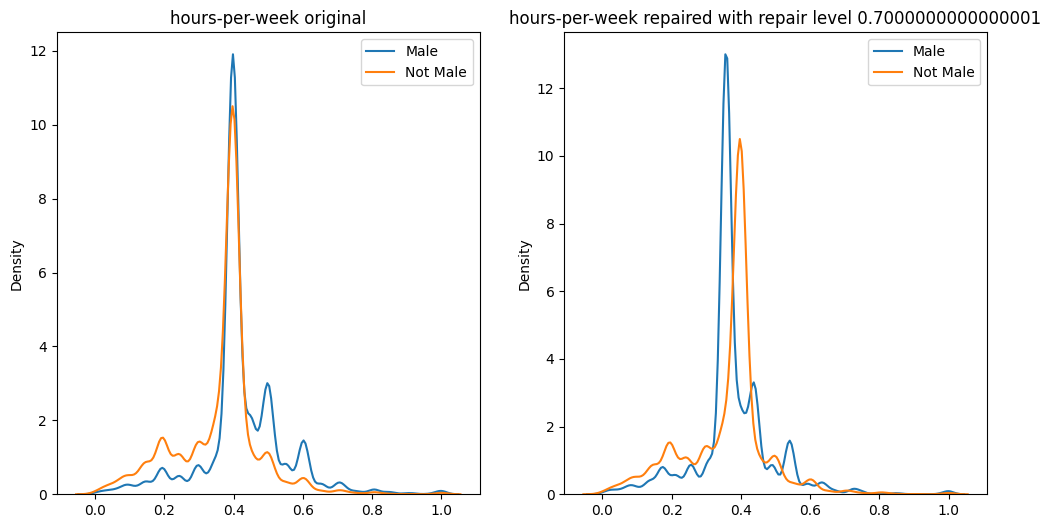

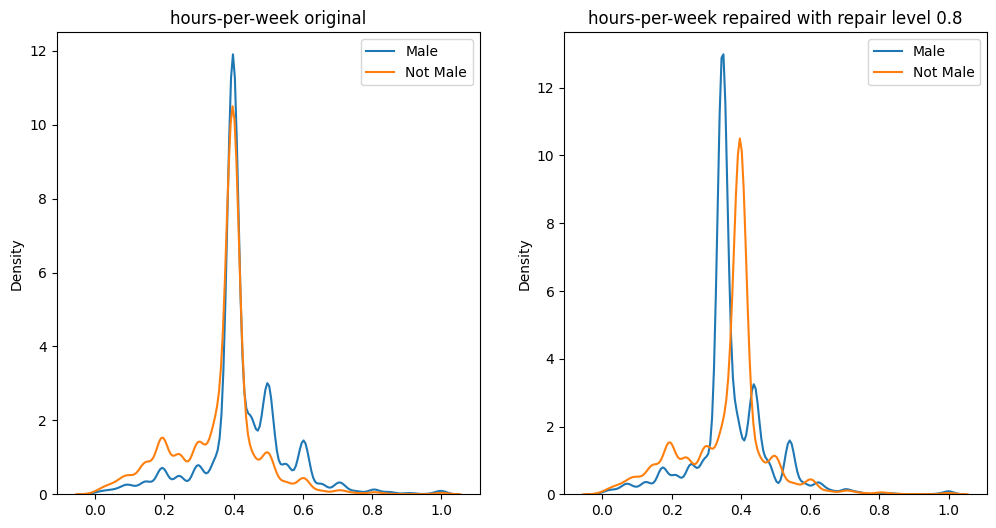

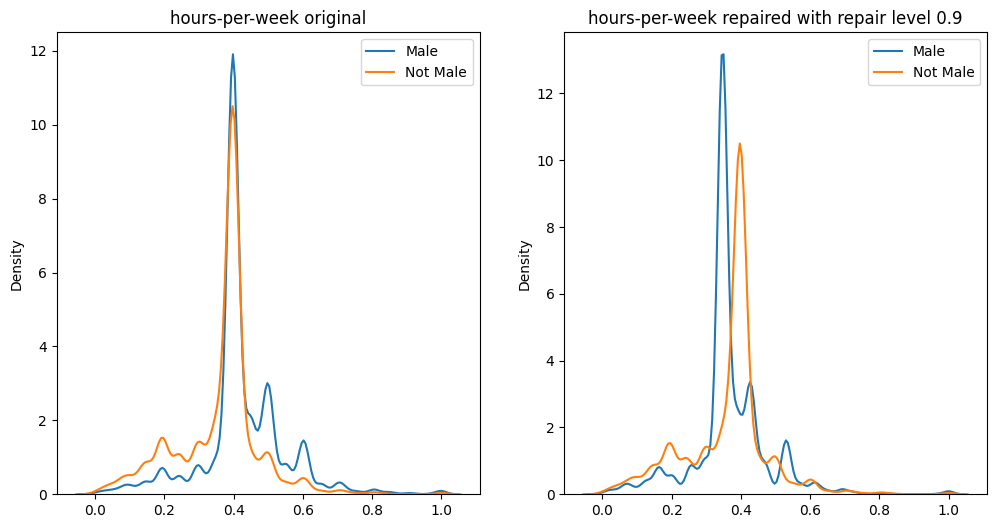

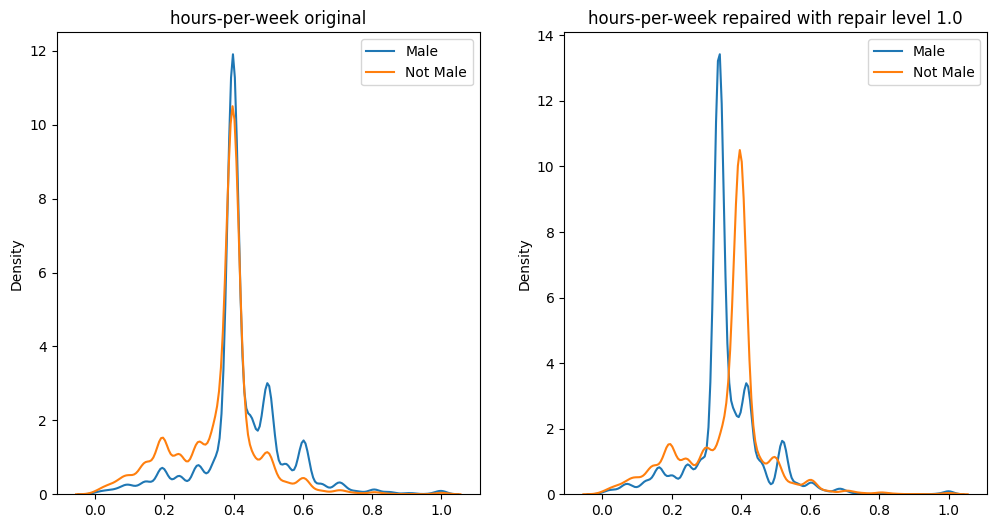

In [11]:
# Initialize an empty list to store Disparate Impact values
accuracies = []
DIs = []


# Feature to be used for histogram visualization
feature_histogram = 'hours-per-week'  # Choosing 'hours-per-week' to observe the impact of repair on its distribution

# Iterate through different repair levels from 0 to 1 with 11 steps
for level in np.linspace(0., 1., 11):
    # Initialize Disparate Impact Remover with the current repair level
    di = DisparateImpactRemover(repair_level=level)

    # Apply Disparate Impact Remover to the training and testing data
    train_repd = di.fit_transform(train)  # Repair the training data
    test_repd = di.fit_transform(test)  # Repair the testing data

    # Plot histograms of the original and repaired data for the specified feature
    plot_histo(feature_histogram, level, train, train_repd)  # Visualize the impact of repair on the feature distribution

    # Prepare the data for model training and evaluation
    # Remove the protected attribute from the features
    X_tr = np.delete(train_repd.features, index, axis=1)
    X_te = np.delete(test_repd.features, index, axis=1)

    # Extract the labels from the repaired training data
    y_tr = train_repd.labels.ravel()  # Training labels

    # Initialize a Logistic Regression model with balanced class weights
    lmod = LogisticRegression(class_weight='balanced', solver='liblinear')

    # Train the Logistic Regression model on the repaired training data
    lmod.fit(X_tr, y_tr)

    # Make predictions on the repaired testing data
    test_repd_pred = test_repd.copy()  # Create a copy of the repaired testing data
    test_repd_pred.labels = lmod.predict(X_te)  # Assign predicted labels to the copy

    # Define privileged and unprivileged groups based on the protected attribute
    p = [{protected: 1}]  # Privileged group (e.g., Male)
    u = [{protected: 0}]  # Unprivileged group (e.g., Female)

    # Calculate the Disparate Impact using the BinaryLabelDatasetMetric
    cm = BinaryLabelDatasetMetric(test_repd_pred, privileged_groups=p, unprivileged_groups=u)
    DIs.append(cm.disparate_impact())

    # Compute and store accuracy
    accuracy = np.mean(test.labels.ravel() == test_repd_pred.labels.ravel())
    accuracies.append(accuracy)

The plot below show the evolution of the disparate impact based on the repair level.

**Your are asked to add the plot of the global accuracy against the repair level.**

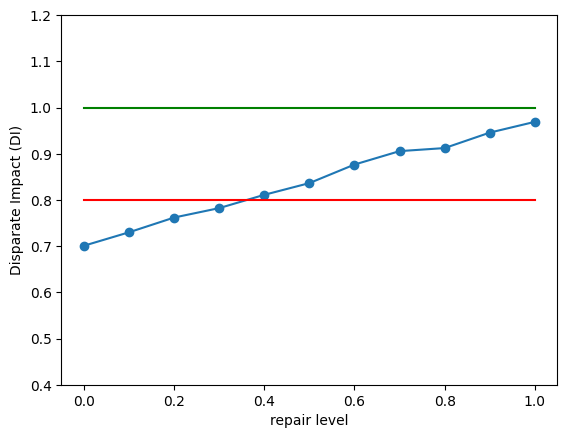

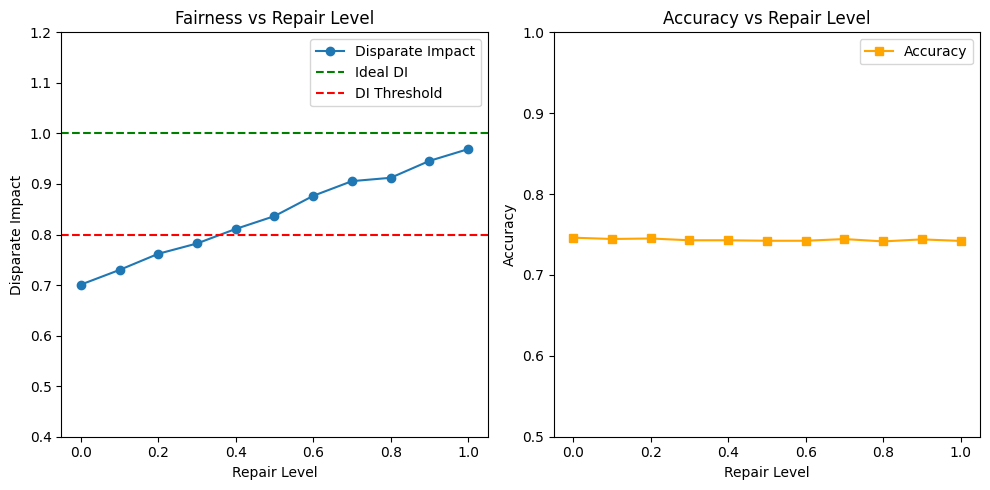

In [12]:
%matplotlib inline

plt.plot(np.linspace(0, 1, 11), DIs, marker='o')
plt.plot([0, 1], [1, 1], 'g')
plt.plot([0, 1], [0.8, 0.8], 'r')
plt.ylim([0.4, 1.2])
plt.ylabel('Disparate Impact (DI)')
plt.xlabel('repair level')
plt.show()


repair_levels = np.linspace(0, 1, 11)

plt.figure(figsize=(10, 5))

# Disparate Impact plot
plt.subplot(1, 2, 1)
plt.plot(repair_levels, DIs, marker='o', label="Disparate Impact")
plt.axhline(1.0, color='green', linestyle='--', label="Ideal DI")
plt.axhline(0.8, color='red', linestyle='--', label="DI Threshold")
plt.ylim([0.4, 1.2])
plt.xlabel("Repair Level")
plt.ylabel("Disparate Impact")
plt.legend()
plt.title("Fairness vs Repair Level")

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(repair_levels, accuracies, marker='s', color='orange', label="Accuracy")
plt.ylim([0.5, 1.0])
plt.xlabel("Repair Level")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Repair Level")

plt.tight_layout()
plt.show()
